# Data Import

In [2]:
# ----- Import required libraries -----
import pandas as pd
from PIL import Image
import io
import cv2
from tqdm import tqdm
import re

## Loading Training Data

In [4]:
from pathlib import Path

# ----- Create path tree -----
root = Path('C:/Users/Shashwat Kumar/Desktop/CodeHub/Projects/Optical Character Recognition')
raw_data = root / 'data' / 'raw_data'

files = [
    # ----- Handwritten Data -----
    raw_data/'hf_handwritten/train.parquet',

    # ----- Printed Data -----
    raw_data/'printed/train-00000-of-00025-e0800a94f785d368.parquet',
    raw_data/'printed/train-00001-of-00025-095e9ac2cb5f0f2f.parquet',
    raw_data/'printed/train-00002-of-00025-fb450bf0c15eb4b9.parquet',
    raw_data/'printed/train-00003-of-00025-3303678227724cd0.parquet',
    raw_data/'printed/train-00004-of-00025-93158a416467d85f.parquet',
    raw_data/'printed/train-00005-of-00025-0b57df213bf40375.parquet'
]

dfs = []

# ----- Show each individual dataframe -----
for path in files:
    print("\n---------- File: ", path.name, "----------")
    df = pd.read_parquet(path)
    dfs.append(df)
    print(df.head())


---------- File:  train.parquet ----------
                                       text  \
0      put down a resolution on the subject   
1        and he is to be backed by Mr. Will   
2     nominating any more Labour life Peers   
3       M Ps tomorrow. Mr. Michael Foot has   
4  Griffiths, M P for Manchester Exchange .   

                                               image  
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  

---------- File:  train-00000-of-00025-e0800a94f785d368.parquet ----------
                                               image            label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...             Lube
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...       Spencerian
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  acc

We eventually need to concatenate all dataframes into one single dataframe object in order to train a ML model. It is observed that some dataframes are in the format ['text', 'image'], while some are of form ['image', 'label']. The varying order and column names will cause conflicts while concatenating the dataframes, hence in order to prevent such issues, we must standardize the dataframes to have consistent name and order formats.

In [6]:
# ----- Function to Standardize all Dataframes -----
def standardize_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reorder columns of all dataframes in ['text', 'image'] format in order to 
    maintain consistency and prevent conflicts during concatenation of dataframes.
    """
    df = df.copy()
    df.columns = [str(c).lower().strip() for c in df.columns]

    if {"image", "label"}.issubset(df.columns):
        df = df.rename(columns={"label": "text"})
    elif {"text", "image"}.issubset(df.columns):
        pass
    else:
        raise ValueError(
            f"Unexpected columns: {list(df.columns)}; need ['image', 'label'] or ['text', 'image']."
        )

    df = df[["text", "image"]]
    df["text"] = df["text"].astype("string")
    return df

# ----- Empty Lists to Append Dataframes -----
df_std = []
df_std_handwritten = []
df_std_printed = []

for path in files:
    df = pd.read_parquet(path)
    df = standardize_col(df)

    # ----- Add Source for Improved Tracking -----
    path_str = str(path)
    if "printed" in path_str:
        df["source"] = "printed"
        df_std_printed.append(df)
    elif "hf_handwritten" in path_str:
        df["source"] = "handwritten"
        df_std_handwritten.append(df)
    else:
        df["source"] = "unknown"

    df_std.append(df)

# ----- Concatenate All Dataframes -----
data_raw = pd.concat(df_std, ignore_index=True)

# ----- Concatenate All Printed Dataframes -----
printed_data = (
    pd.concat(df_std_printed, ignore_index=True)
    if df_std_printed
    else data_raw.iloc[0:0].copy()
)

# ----- Concatenate All Handwritten Dataframes -----
handwritten_data = (
    pd.concat(df_std_handwritten, ignore_index=True)
    if df_std_handwritten
    else data_raw.iloc[0:0].copy()
)


In [7]:
print(" \n---------- Handwritten and Printed Data ----------\n")
print(data_raw)
print(data_raw.shape)

print(" \n---------- Handwritten Data ----------\n")
print(handwritten_data)
print(handwritten_data.shape)

print(" \n---------- Printed Data ----------\n")
print(printed_data)
print(printed_data.shape)

 
---------- Handwritten and Printed Data ----------

                                             text  \
0            put down a resolution on the subject   
1              and he is to be backed by Mr. Will   
2           nominating any more Labour life Peers   
3             M Ps tomorrow. Mr. Michael Foot has   
4        Griffiths, M P for Manchester Exchange .   
...                                           ...   
1740381                                  INDIRECT   
1740382                                  EMULATES   
1740383                                 unbosomed   
1740384                                crankcases   
1740385                                  LEAFLETS   

                                                     image       source  
0        {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  handwritten  
1        {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  handwritten  
2        {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  handwritten  
3        {'by

## Loading Test Data

In [9]:
files = [
    # ----- Handwritten Data -----
    raw_data/'hf_handwritten/test.parquet',

    # ----- Printed Data -----
    raw_data/'printed/test-00000-of-00003-93cdf7f5b5af49ee.parquet',
    raw_data/'printed/test-00001-of-00003-1004494b2249dc53.parquet',
]

data_test_raw = []

for path in files:
    df = pd.read_parquet(path)
    df = standardize_col(df)
    data_test_raw.append(df)

data_test_raw = pd.concat(data_test_raw, ignore_index=True)

data_test_raw

,text,image
0,"assuredness "" Bella Bella Marie "" ( Parlophone...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,I don't think he will storm the charts with th...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,"CHRIS CHARLES , 39 , who lives in Stockton-on-...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,Become a success with a disc and hey presto ! ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,"Tolch , as he is known in Tin Pan Alley , like...",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
...,...,...
597526,Poetic,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
597527,payment,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
597528,TABLETOPS,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
597529,SPLURGED,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


## Loading Validation Data

In [11]:
files = [
    # ----- Handwritten Data -----
    raw_data/'hf_handwritten/validation.parquet',

    # ----- Printed Data -----
    raw_data/'printed/val-00000-of-00003-1e8934522df1dd51.parquet',
    raw_data/'printed/val-00001-of-00003-e0f0985559c5db2f.parquet',
]

data_val_raw = []

for path in files:
    df = pd.read_parquet(path)
    df = standardize_col(df)
    data_val_raw.append(df)

data_val_raw = pd.concat(data_val_raw, ignore_index=True)

data_val_raw

,text,image
0,It was a splendid interpretation of the,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,sympathetic C O . Paul Daneman gave another,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,"part . The rest of the cast were well chosen ,",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,with James Maxwell making a fine job of the,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,""" The Little Key . """,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
...,...,...
536127,cations,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
536128,MASOCHISTS,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
536129,Chompers,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
536130,randell,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


## Save Concatenated Files

In [13]:
out_dir = "C:/Users/Shashwat Kumar/Desktop/CodeHub/Projects/Optical Character Recognition/data/raw_data"

data_raw.to_parquet(f"{out_dir}/train_raw.parquet", index=False)
data_test_raw.to_parquet(f"{out_dir}/test_raw.parquet", index=False)
data_val_raw.to_parquet(f"{out_dir}/val_raw.parquet", index=False)

# Exploratory Data Analysis

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
import seaborn as sns
from collections import Counter
%matplotlib inline

In [16]:
# ----- Check Handwritten Images -----
img_byte = handwritten_data.loc[0, "image"]["bytes"]

img = Image.open(io.BytesIO(img_byte))
img.show()

In [17]:
# ----- Check Printed Images -----
img_byte = printed_data.loc[0, "image"]["bytes"]

img = Image.open(io.BytesIO(img_byte))
img.show()

## Dataset Structure

In [19]:
# ----- Sample Count -----
print("Training Set: ", data_raw.shape)
print("Testing Set: ", data_test_raw.shape)
print("Validation Set: ", data_val_raw.shape)

Training Set:  (1740386, 3)
Testing Set:  (597531, 2)
Validation Set:  (536132, 2)


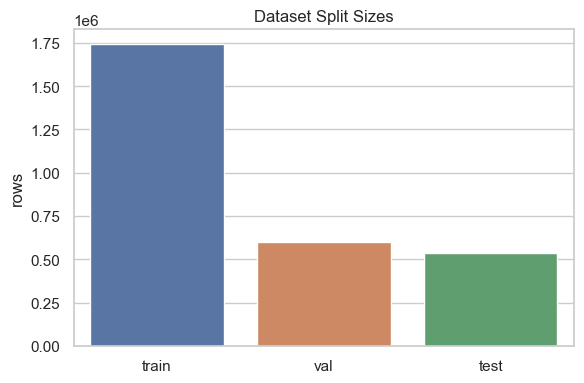

In [20]:
# ----- Bar Plot for Sample Count -----
labels = ["train", "val", "test"]
values = [len(data_raw), len(data_test_raw), len(data_val_raw)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))

ax = sns.barplot(x= labels, hue = labels, y=values, palette="deep", legend = False)
ax.set_title("Dataset Split Sizes")
ax.set_xlabel("")
ax.set_ylabel("rows")

plt.tight_layout()
plt.show()

The dataset split is dominated by the training set, which is desirable as it maximizes the data available for model learning. The validation and test sets are smaller but sufficiently large to provide meaningful evaluation.

Text(0.5, 1.0, 'Handwritten vs Printed')

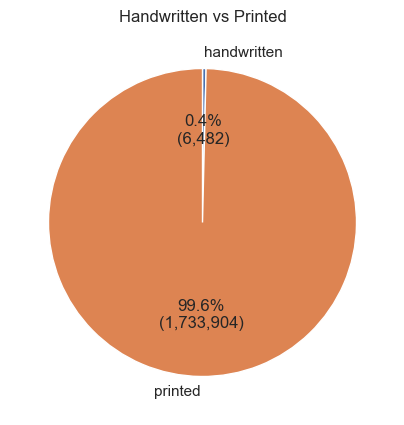

In [22]:
# ----- Pie Chart to Determine Class Imbalance -----

labels = ["handwritten", "printed"]
sizes = [len(handwritten_data), len(printed_data)]

plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100*sum(sizes))):,})",
    startangle=90,
    counterclock=False,
)
plt.title("Handwritten vs Printed")

The dataset is highly imbalanced, with printed text constituting ~99.6% and handwritten text only ~0.4%. Without corrective measures, the model may overfit to printed text. Techniques such as oversampling, augmentation of handwritten samples, or applying class weights during training will be necessary to achieve balanced performance. Even still such methods might not be sufficient to create a balanced dataset, hence a certain portion of printed text must be removed to introduce class balance.

## Image Level Analysis

**NOTE:** Log scaling is done in order to prevent concentration of tickers near origin. This behaviour is observed due to image dimension possible having high standard deviation.

### Extracting Metadata

In [27]:
# ----- Function to Extract Image Size and Width -----
def extract_dim(img_dict):
    if not isinstance(img_dict, dict) or "bytes" not in img_dict:
        return None, None
    with Image.open(io.BytesIO(img_dict["bytes"])) as im:
        return im.width, im.height

df_dim = data_raw.copy()
df_dim[["width", "height"]] = df_dim["image"].map(extract_dim).apply(pd.Series)

### Dimensional Analysis

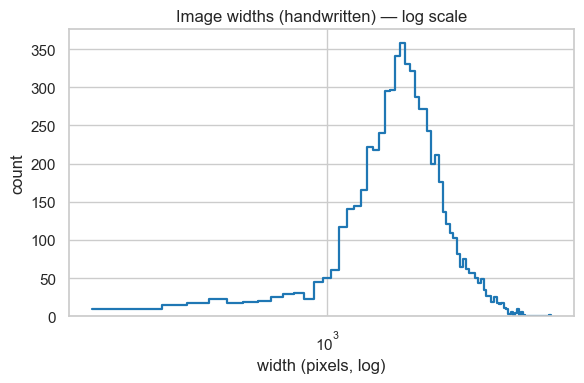

In [29]:
# ----- Ensure Positive Values for Log Scaling -----
df_plot = df_dim[(df_dim["width"] > 0) & (df_dim["height"] > 0)].copy()

# ----- Histogram - Widths Handwritten -----
d = df_plot[df_plot["source"] == "handwritten"]

plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=d,
    x="width",
    bins=80,
    element="step",
    fill=False,
    stat="count",
    linewidth=1.6,
    color="tab:blue",
)
ax.set_xscale("log")
ax.set_title("Image widths (handwritten) — log scale")
ax.set_xlabel("width (pixels, log)")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

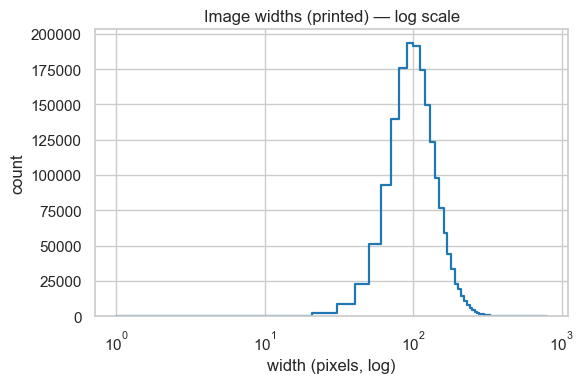

In [30]:
# ----- Histogram - Widths Printed -----
d = df_plot[df_plot["source"] == "printed"]

plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=d,
    x="width",
    bins=80,
    element="step",
    fill=False,
    stat="count",
    linewidth=1.6,
    color="tab:blue",
)
ax.set_xscale("log")
ax.set_title("Image widths (printed) — log scale")
ax.set_xlabel("width (pixels, log)")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

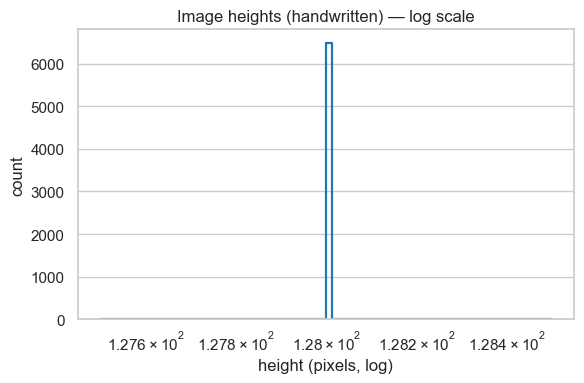

In [31]:
# ----- Histogram - Heights Handwritten -----
d = df_plot[df_plot["source"] == "handwritten"]

plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=d,
    x="height",
    bins=80,
    element="step",
    fill=False,
    stat="count",
    linewidth=1.6,
    color="tab:blue",
)
ax.set_xscale("log")
ax.set_title("Image heights (handwritten) — log scale")
ax.set_xlabel("height (pixels, log)")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()



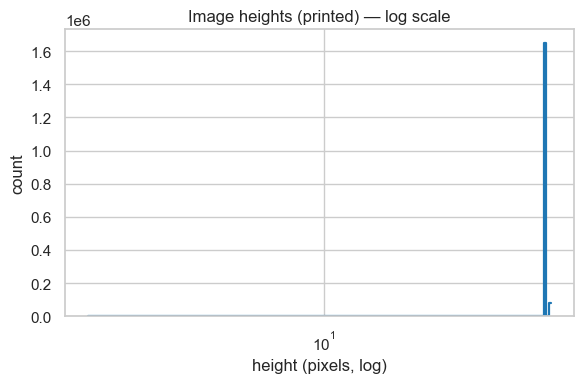

In [32]:
# ----- Histogram - Heights Printed -----
d = df_plot[df_plot["source"] == "printed"]

plt.figure(figsize=(6, 4))
ax = sns.histplot(
    data=d,
    x="height",
    bins=80,
    element="step",
    fill=False,
    stat="count",
    linewidth=1.6,
    color="tab:blue",
)
ax.set_xscale("log")
ax.set_title("Image heights (printed) — log scale")
ax.set_xlabel("height (pixels, log)")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

Handwritten heights are nearly constant (~128 px), implying fixed‑height preprocessing; widths vary widely, indicating variable aspect ratios. Printed images show multiple common heights and a very large sample size, with widths concentrated in the low‑hundreds of pixels (log scale) and a long tail. Overall, handwritten exhibits larger width variability than printed, while printed dominates volume.

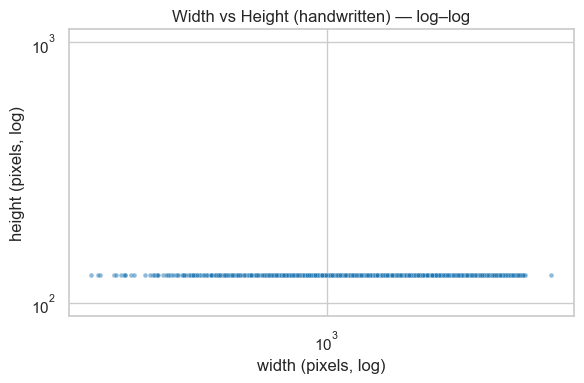

In [34]:
# ----- Width vs Height Scatter Plot for Handwritten -----
d = df_plot[df_plot["source"] == "handwritten"]

plt.figure(figsize=(6, 4))
ax = sns.scatterplot(
    data=d,
    x="width",
    y="height",
    s=12,
    alpha=0.5,
    color="tab:blue",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Width vs Height (handwritten) — log–log")
ax.set_xlabel("width (pixels, log)")
ax.set_ylabel("height (pixels, log)")
plt.tight_layout()
plt.show()


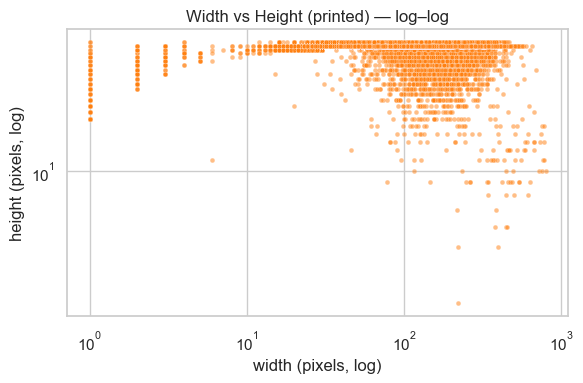

In [35]:
# # ----- Width vs Height Scatter Plot for Printed -----
d = df_plot[df_plot["source"] == "printed"]

plt.figure(figsize=(6, 4))
ax = sns.scatterplot(
    data=d,
    x="width",
    y="height",
    s=12,
    alpha=0.5,
    color="tab:orange",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Width vs Height (printed) — log–log")
ax.set_xlabel("width (pixels, log)")
ax.set_ylabel("height (pixels, log)")
plt.tight_layout()
plt.show()


Scatter plots confirm precious observations. Fixed size resizing or bucketing may be necessary for optimal accuracy.

### Pixel Density Analysis

In order to determine pixel density, we must first conver all images to greyscale and

#### Define Metrics and Implement Batching:

In order to calculate **dark pixel proportion**, we will use **otsu's method** which automatically adjusts threshold value per image to best seperate foreground with background. Along wiht this, we will use a secondary metric - **mean dark pixel proportion** - to confirm our threshold values with those produced by otsu's method.

**Batching** is implemented so in order to optimize hardware resources i.e. for EDA it allows us to experiment on a sample of a dataset so as to hopefully figure out a pattern.

**Note:** tqdm is a library which displays a progress bar to track processes which may be time consuming.

In [41]:
# ----- Function to Decode Raw Bytes and Convert to Grayscale -----
def to_gray(x):
    arr = np.frombuffer(x['bytes'], dtype=np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)


# ----- Compute Dark Pixel Proportion (Otsu threshold) -----
def dpr_otsu(x):
    g = to_gray(x)
    if g is None:
        return np.nan
    _, b = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return float((b.sum() / 255.0) / b.size)


# ----- Mean Darkness -----
def mdark(x):
    g = to_gray(x)
    if g is None:
        return np.nan
    return float(1.0 - (g.mean() / 255.0))

In [42]:
# ----- Batching to Optimize Memory -----
def add_density(df, batch=8000, do_mean=False):
    out = df.reset_index(drop=True).copy()
    n = len(out)
    vals = np.empty(n, dtype=np.float32)
    vals2 = np.empty(n, dtype=np.float32) if do_mean else None

    for s in tqdm(range(0, n, batch), desc='batches'):
        e = min(s + batch, n)
        imgs = out.loc[s:e-1, 'image'].tolist()
        vals[s:e] = [dpr_otsu(x) for x in imgs]
        if do_mean:
            vals2[s:e] = [mdark(x) for x in imgs]

    out['dpr_otsu'] = vals
    if do_mean:
        out['mdark'] = vals2
    return out

#### Compute Dark Pixel Proportion

In [44]:
# ----- Extract Sample from Dataset -----
df_sample = data_raw.sample(n=50000, random_state=42)[['image','source']]

# ----- Add Dark Pixel Density to Dataframe -----
df_den = add_density(df_sample, batch=8000, do_mean=True)

batches: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


#### Analyze Threshold Values

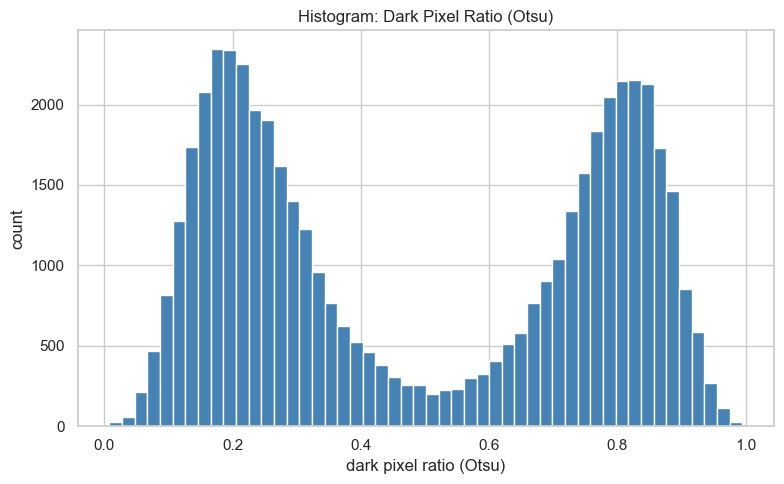

In [46]:
# ----- DPR Otsu's Method -----
s = pd.Series(df_den['dpr_otsu']).dropna()

plt.figure(figsize=(8,5))
plt.hist(s, bins=50, color='steelblue', edgecolor='white')
plt.title('Histogram: Dark Pixel Ratio (Otsu)')
plt.xlabel('dark pixel ratio (Otsu)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

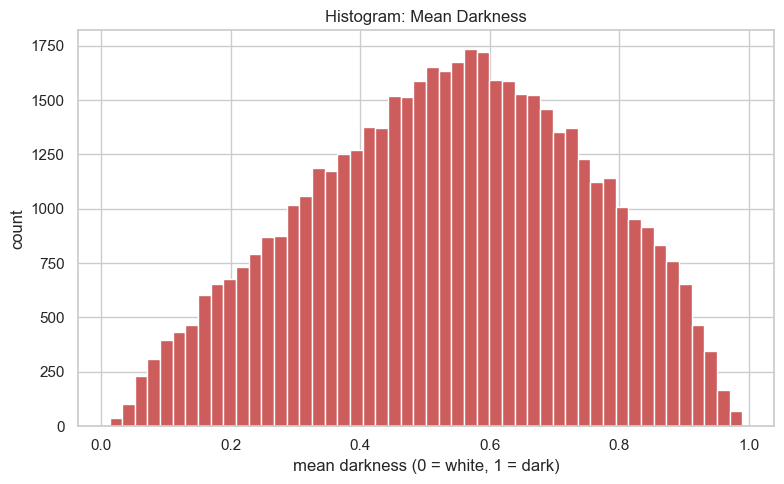

In [47]:
# ----- DPR Mean Darkness Method -----
s = pd.Series(df_den['mdark']).dropna()

plt.figure(figsize=(8,5))
plt.hist(s, bins=50, color='indianred', edgecolor='white')
plt.title('Histogram: Mean Darkness')
plt.xlabel('mean darkness (0 = white, 1 = dark)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

Otsu dark pixel ratio (dpr_otsu) is bimodal, indicating two regimes: sparse pages with lots of background and dense, text-heavy pages. This likely reflects a mix of full-page scans vs. tight text crops or varied scan qualities.

Mean darkness (mdark) shows the complementary trend: higher for dense pages, lower for sparse ones. The “opposite” shapes arise because dpr_otsu counts foreground area after binarization, while mdark averages overall tone.

## Image Noise and Quality Analysis

This analysis aims to ascertain the following metrics:
- **Noise**: Random pixel variations or unwanted artifacts that degrade image quality
- **Blur**: Loss of sharpness where edges and details become soft or unfocused due to motion, defocus, or processing.
- **Skew**: Geometric distortion where the image appears tilted, rotated, or warped from its intended rectangular alignment.

### Noise Analysis

Generally we have two common methods to determine noise in images:
- **Residual Mean Absolute Deviation (MAD)**
- **Background High Frequencey Energy**

We will proceed with residual MAD as it is robust to outliers and illumination gradients, requires no masking, and is computationally light, making it ideal for large, heterogeneous datasets where a single, stable noise KPI is needed. If later the goal shifts to quantifying background texture specifically, we can optionally utilize background high frequency energy method.

In [53]:
# ----- Function to Calculate Noise Score -----
def noise_mad(g):
    if g is None:
        return np.nan

    blur = cv2.medianBlur(g, 3)
    resid = g.astype(np.int16) - blur.astype(np.int16)

    mad = np.median(np.abs(resid))
    return float(mad)

# ----- Function to Add Noise Score using Batching -----
def add_noise_mad(df, batch=8000, image_col='image'):
    out = df.reset_index(drop=True).copy()
    n = len(out)
    vals = np.empty(n, dtype=np.float32)

    for s in tqdm(range(0, n, batch), desc='mad-batches'):
        e = min(s + batch, n)
        imgs = out.iloc[s:e][image_col].tolist()
        for i, x in enumerate(imgs):
            g = to_gray(x)
            vals[s+i] = noise_mad(g)

    out['noise_mad'] = vals
    return out

In [54]:
# ----- Sample 200K Entities -----
df_sample = data_raw[['image']].sample(n=200000, random_state=42)

# ----- Compute Noise on Sample -----
df_no = add_noise_mad(df_sample, batch=8000)

mad-batches: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.55it/s]


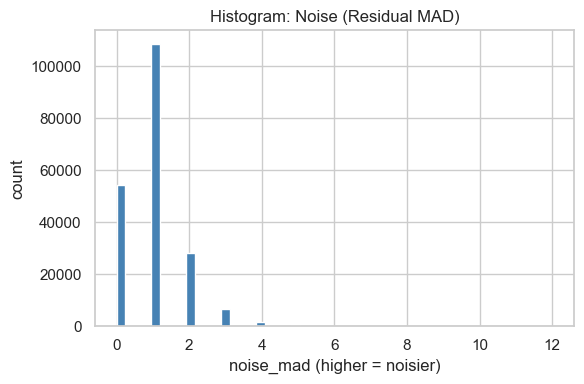

In [55]:
# ----- Histogram to Show Noise Score -----
s = pd.Series(df_no['noise_mad']).dropna()
plt.figure(figsize=(6,4))
plt.hist(s, bins=50, color='steelblue', edgecolor='white')
plt.title('Histogram: Noise (Residual MAD)')
plt.xlabel('noise_mad (higher = noisier)')
plt.ylabel('count')
plt.tight_layout()
plt.show()

Residual-MAD noise is heavily right-skewed with most pages clustered at very low values, indicating generally clean scans. A small tail extends to higher MAD, flagging a minority of noisy pages. We should ideally set a data-driven threshold to auto-flag noisy pages for review/denoising. Due to Residual MAD being illumination-robust, higher score are mostly due to true high-frequency rather than gradient deltas.

### Blur Analysis

Blur is computed through **Variance of Laplacian**, which measures the spread of second-derivative responses. Sharp images have strong edges -> large Laplacian responses -> high variance. Blurry images suppress edges -> small responses -> low variance. The score is interpreted as lower score = blurrier; higher score = sharper

In [59]:
# ----- Function to Calculate Blur Score -----
def blur_score(g):
    if g is None:
        return np.nan
    lap = cv2.Laplacian(g, cv2.CV_64F, ksize=3)
    return float(lap.var()) 

# ----- Function to Record Blur Score -----
def add_blur(df, batch=8000, image_col='image'):
    out = df.reset_index(drop=True).copy()
    n = len(out)
    vals = np.empty(n, dtype=np.float64)

    for s in tqdm(range(0, n, batch), desc='blur-batches'):
        e = min(s + batch, n)
        imgs = out.iloc[s:e][image_col].tolist()
        for i, x in enumerate(imgs):
            g = to_gray(x)
            vals[s+i] = blur_score(g)

    out['blur_var_lap'] = vals
    return out

In [60]:
# ----- Sample 200K Entities -----
df_sample = data_raw[['image']].sample(n=200000, random_state=42)

# ----- Compute Blur Score -----
df_blr = add_blur(df_sample, batch = 5000)

blur-batches: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.40it/s]


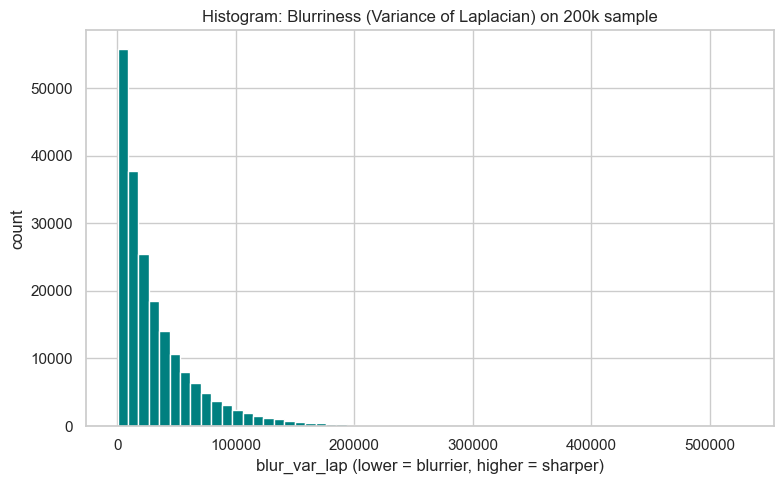

In [61]:
# ----- Histogram to Visulaise Blur -----
s = pd.Series(df_blr['blur_var_lap']).dropna()

plt.figure(figsize=(8,5))
plt.hist(s, bins=60, color='teal', edgecolor='white')
plt.title('Histogram: Blurriness (Variance of Laplacian) on 200k sample')
plt.xlabel('blur_var_lap (lower = blurrier, higher = sharper)')
plt.ylabel('count')

plt.tight_layout()
plt.show()

In [62]:
# ----- Compute Quantiles for Blur -----
print('Quantiles (blur_var_lap):', s.quantile([0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99]).round(2).to_dict())

Quantiles (blur_var_lap): {0.01: 870.47, 0.05: 1951.01, 0.1: 3240.11, 0.5: 19657.98, 0.9: 76616.47, 0.95: 103081.05, 0.99: 163714.56}


The blur score (variance of Laplacian) is strongly right‑skewed: most pages cluster at low–moderate values, with a long tail toward high values. Lower scores indicate blurrier images; higher scores indicate sharper edges. The bulk of pages have modest edge strength (some blur present), while a minority are very sharp. The extreme low end likely contains genuinely blurry or motion‑blurred scans.

### Skewness

We will utilise **Hough-Based Skew Metrics** to evaluate skenwess. This metric estimates how much a document is tilted by detecting dominant near‑horizontal lines and summarizing their orientation. The process includes the following steps:
- **Boreder Masking:**  Remove a thin band along the page edges before processing.
- **Light blur + edge detection:** Apply a small Gaussian blur and then Canny edge detection(finds edges in images by detecting rapid changes in pixel intensity).
- **Hough transform:** Vote-based line detection in (rho, theta) space from the edge map.
- **Robust aggregation:** Convert kept line angles to degrees, trim outliers using MAD, and take the median

In [66]:
# ----- Function to Compute Sknewness -----
def skew_hough_deg(g, canny1=50, canny2=150, hough_th=150, border_frac=0.04, angle_win=30):
    """
    Returns median skew angle in degrees (positive = clockwise).
    - border_frac: mask this fraction on each image edge to ignore borders
    - angle_win: keep only lines within +/- angle_win/2 degrees around horizontal
    """
    if g is None:
        return np.nan

    h, w = g.shape[:2]

    # ----- Mask page borders -----
    bf = int(border_frac * min(h, w))
    mask = np.zeros_like(g, np.uint8)
    cv2.rectangle(mask, (bf, bf), (w - bf - 1, h - bf - 1), 255, -1)
    g_mask = cv2.bitwise_and(g, g, mask=mask)

    # ----- Light blur + edge detection -----
    gb = cv2.GaussianBlur(g_mask, (3, 3), 0)
    edges = cv2.Canny(gb, canny1, canny2, L2gradient=True)

    # ----- Hough transform -----
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=hough_th)
    if lines is None or len(lines) == 0:
        return 0.0

    # ----- Convert to degrees -----
    angles = []
    half = angle_win / 2.0
    for rho, theta in lines[:, 0]:
        deg = np.degrees(theta)
        # ----- map to [-90, 90] -----
        if deg > 90:
            deg -= 180
        # ----- Keep near-horizontal -----
        if -half <= deg <= half:
            angles.append(deg)

    if not angles:
        return 0.0

    # ----- Robust Aggregation: trim outliers and take median -----
    a = np.array(angles, dtype=np.float32)
    med = np.median(a)
    mad = np.median(np.abs(a - med)) + 1e-6
    keep = np.abs(a - med) <= 3 * 1.4826 * mad
    if keep.sum() >= 5:
        return float(np.median(a[keep]))
    return float(med)

# ----- Append Skewness -----
def add_skew_hough(df, batch=5000, image_col='image'):
    out = df.reset_index(drop=True).copy()
    n = len(out)
    vals = np.empty(n, dtype=np.float32)
    for s in tqdm(range(0, n, batch), desc='skew-hough'):
        e = min(s + batch, n)
        imgs = out.iloc[s:e][image_col].tolist()
        for i, x in enumerate(imgs):
            g = to_gray(x)
            vals[s + i] = skew_hough_deg(g)
    out['skew_deg_hough'] = vals
    return out

In [67]:
# ----- Sample 200K Entities -----
df_sample = data_raw[['image']].sample(n=200000, random_state=42)

# ----- Compute Blur Score -----
df_skw = add_skew_hough(df_sample, batch = 5000)

skew-hough: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [01:01<00:00,  1.53s/it]


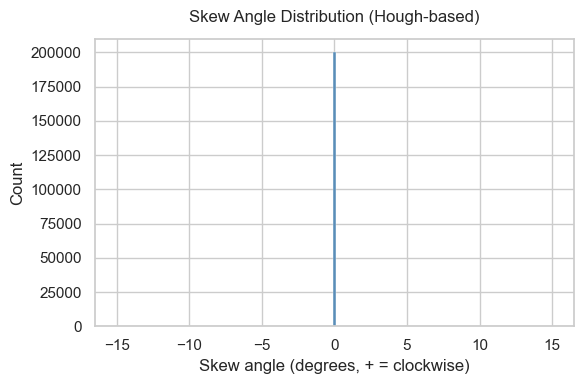

In [68]:
s = pd.Series(df_skw['skew_deg_hough']).dropna()

plt.figure(figsize=(6,4))
sns.histplot(s, bins=121, binrange=(-15, 15), color='steelblue', edgecolor='white', alpha=0.85, kde=True, stat='count')
plt.title('Skew Angle Distribution (Hough-based)', pad=12)
plt.xlabel('Skew angle (degrees, + = clockwise)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The Hough-based skew angles concentrate almost entirely at 0°, indicating the vast majority of pages are effectively upright with negligible tilt. This suggests scanning pipelines are well aligned and deskewing will yield limited gains overall.

## Text Level Analysis

Text Level Analytics consists of the following experimentation:
- Text Length Analysis
- Character Frequence Distribution
- Rare Character Frequency

### Text Length Analysis

In [73]:
# ----- Extract Dataframe of Text -----
df_txt = data_raw[['text']].copy()

# ----- Function for Character Length -----
def safe_len(x):
    return len(x) if isinstance(x, str) else 0

# ----- Function to Identify Words -----
def word_tokens(x):
    if not isinstance(x, str): return []
    return re.findall(r"\w+(?:'\w+)?", x, flags=re.UNICODE)

# ----- Function to Identify Sentences -----
def sentence_tokens(x):
    if not isinstance(x, str): return []
    x = x.strip()
    return re.split(r'(?<=[.!?])\s+', x) if x else []

# ----- Add Text Level Length -----
df_txt['len_char'] = df_txt['text'].apply(safe_len)
df_txt['len_word'] = df_txt['text'].apply(lambda t: len(word_tokens(t)))
df_txt['len_sent'] = df_txt['text'].apply(lambda t: len(sentence_tokens(t)))

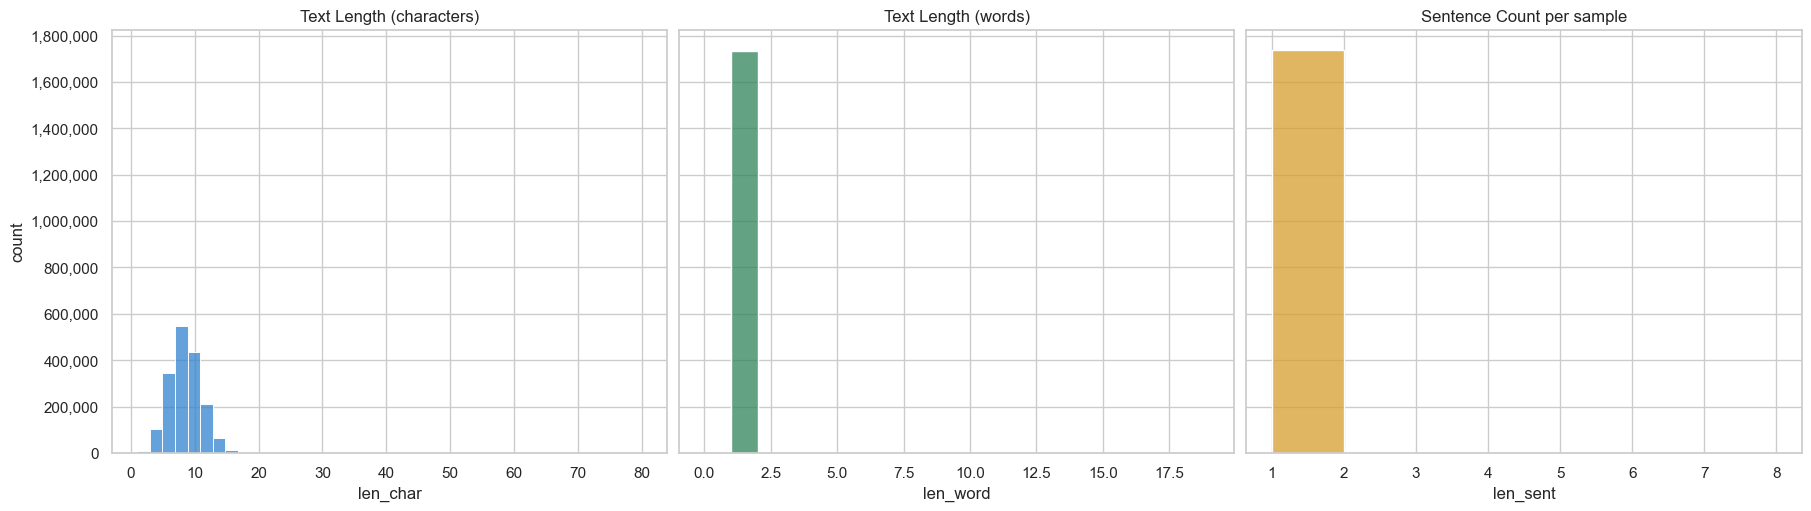

In [74]:
# ----- Histogram to Display Text Level Frequency -----
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True, constrained_layout=True)

# ----- Assert Intgeral Ticks -----
fmt_int = FuncFormatter(lambda x, p: f"{int(x):,}")

# ----- Character length -----
sns.histplot(df_txt['len_char'], bins=40, color='#3182ce', edgecolor='white', ax=axes[0])
axes[0].set_title('Text Length (characters)')
axes[0].set_xlabel('len_char'); axes[0].set_ylabel('count')

# ----- Word length -----
sns.histplot(df_txt['len_word'], bins=np.arange(df_txt['len_word'].min(), df_txt['len_word'].max()+2), 
             color='#2f855a', edgecolor='white', ax=axes[1])
axes[1].set_title('Text Length (words)')
axes[1].set_xlabel('len_word')

# ----- Sentence count -----
sns.histplot(df_txt['len_sent'], bins=np.arange(df_txt['len_sent'].min(), df_txt['len_sent'].max()+2), 
             color='#d69e2e', edgecolor='white', ax=axes[2])
axes[2].set_title('Sentence Count per sample')
axes[2].set_xlabel('len_sent')

# ----- Standardize Y ticks -----
for ax in axes:
    ax.yaxis.set_major_formatter(fmt_int)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ymax = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(0, ymax)

plt.show()

Most samples are short snippets: character lengths cluster tightly around roughly 6–12 characters, while word counts are overwhelmingly 1–2 and sentence counts are almost always exactly 1. This implies the corpus is dominated by isolated words or very short phrases rather than full sentences or paragraphs. Modeling-wise, a character-level or short-sequence CTC setup is appropriate; long-context sequence modeling isn’t necessary

### Text Distribution Analysis

In [77]:
# ----- Function to Count Characters -----
char_counter = Counter()
for t in data_raw['text']:
    if isinstance(t, str):
        char_counter.update(list(t))

# ----- Convert Count List to Dataframe -----
char_df = pd.DataFrame(char_counter.items(), columns=['char','count']).sort_values('count', ascending=False).reset_index(drop=True)
char_df['freq'] = char_df['count'] / char_df['count'].sum()

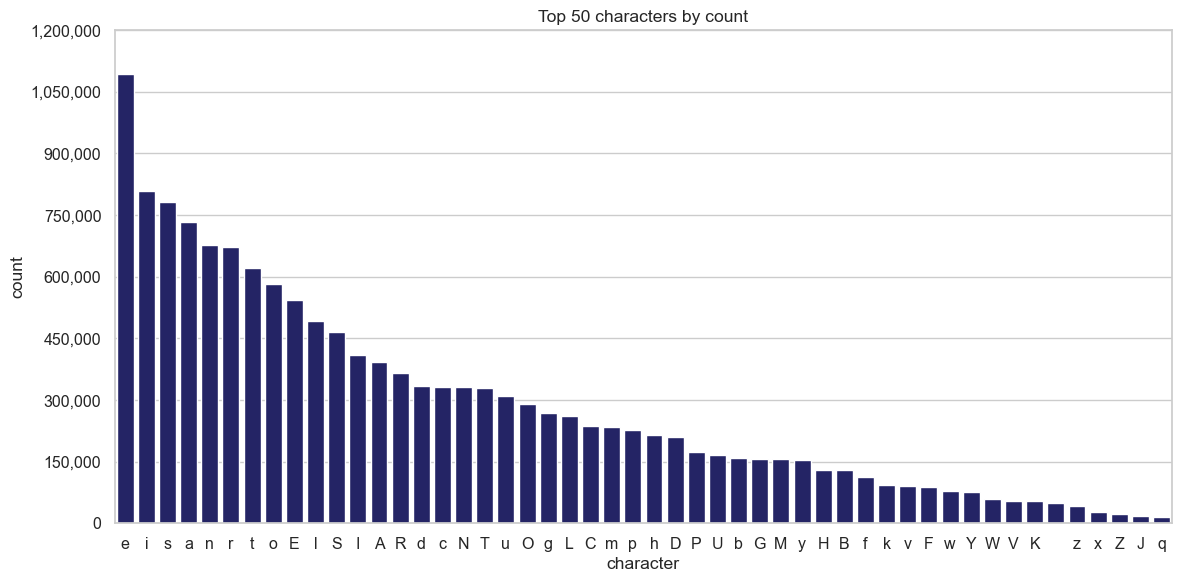

In [78]:
# ----- Distribution of Top 50 Chacracters -----
sns.set(style='whitegrid', context='notebook', font_scale=1.05)

N = 50
plot_df = char_df.head(N).copy()

plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df, x='char', y='count', color='midnightblue', edgecolor='white')

# ----- Disable Scientific Notation -----
sf = ScalarFormatter(useOffset=False, useMathText=False)
sf.set_scientific(False)
ax.yaxis.set_major_formatter(sf)

# ----- Format Y ticks -----
ax.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{int(x):,}"))

ylim = ax.get_ylim()[1]
round_to = 100_000
ax.set_ylim(0, int((ylim + round_to - 1) // round_to * round_to))

# ----- Labelling -----
plt.title(f"Top {N} characters by count")
plt.xlabel("character"); plt.ylabel("count")

plt.tight_layout()
plt.show()

Distribution is highly skewed: a small set of characters dominates (e, i, s, a, n, r, t, o), while the tail contains infrequent letters (z, x, J, Q). Lowercase letters far outnumber uppercase; digits/symbols barely appear among the top 50. For modelling we must prioritize coverage and augmentation for the head characters i.e. add class balancing or sampling for rare-tail characters to avoid bias.

### Rare Charcter Identification

In [81]:
# ----- Define Rarity Cutoffs -----
min_count = 100
min_freq  = 1e-5

rare_char = char_df[(char_df['count'] < min_count) | (char_df['freq'] < min_freq)].copy()

# ----- Format Display -----
import pandas as pd
pd.set_option('display.width', 140)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.float_format', lambda x: f'{x:,.8f}')

# ----- Format View -----
out = rare_char.copy()
out['count'] = out['count'].map(lambda x: f'{int(x):,}')
out['freq']  = out['freq'].map(lambda x: f'{x:.8f}')
out['pct']   = (rare_char['freq'] * 100).map(lambda x: f'{x:.6f}%')

print('Rare characters (first 30):')
print(out.head(30).to_string(index=False))

Rare characters (first 30):
char count       freq       pct
   !   105 0.00000730 0.000730%
   (    95 0.00000661 0.000661%
   )    93 0.00000647 0.000647%
   :    91 0.00000633 0.000633%
   ;    84 0.00000584 0.000584%
   ?    63 0.00000438 0.000438%
   #    52 0.00000362 0.000362%
   &    38 0.00000264 0.000264%
   /    16 0.00000111 0.000111%
   *     8 0.00000056 0.000056%
   +     2 0.00000014 0.000014%


In [82]:
import os

# ----- Target Directory -----
out_dir = r"C:\Users\Shashwat Kumar\Desktop\CodeHub\Projects\Optical Character Recognition\data"
os.makedirs(out_dir, exist_ok=True)

# ----- Full Path
out_path = os.path.join(out_dir, "rare_characters.csv")

# ----- Save Rare Word for Future Use -----
rare_char.to_csv(out_path, index=False)
print(f"Saved to: {out_path}")

Saved to: C:\Users\Shashwat Kumar\Desktop\CodeHub\Projects\Optical Character Recognition\data\rare_characters.csv


# Summary Of EDA

- The dataset split is dominated by the training set, which is desirable as it maximizes the data available for model learning. The validation and test sets are smaller but sufficiently large to provide meaningful evaluation.

- The dataset is highly imbalanced, with printed text constituting ~99.6% and handwritten text only ~0.4%. Without corrective measures, the model may overfit to printed text. Techniques such as oversampling, augmentation of handwritten samples, or applying class weights during training will be necessary to achieve balanced performance. Even still such methods might not be sufficient to create a balanced dataset, hence a certain portion of printed text must be removed to introduce class balance.

- Handwritten heights are nearly constant (~128 px), implying fixed‑height preprocessing; widths vary widely, indicating variable aspect ratios. Printed images show multiple common heights and a very large sample size, with widths concentrated in the low‑hundreds of pixels (log scale) and a long tail. Overall, handwritten exhibits larger width variability than printed, while printed dominates volume.

- Otsu dark pixel ratio (dpr_otsu) is bimodal, indicating two regimes: sparse pages with lots of background and dense, text-heavy pages. This likely reflects a mix of full-page scans vs. tight text crops or varied scan qualities. Mean darkness (mdark) shows the complementary trend: higher for dense pages, lower for sparse ones. The “opposite” shapes arise because dpr_otsu counts foreground area after binarization, while mdark averages overall tone.

- Residual-MAD noise is heavily right-skewed with most pages clustered at very low values, indicating generally clean scans. A small tail extends to higher MAD, flagging a minority of noisy pages. We should ideally set a data-driven threshold to auto-flag noisy pages for review/denoising. Due to Residual MAD being illumination-robust, higher score are mostly due to true high-frequency rather than gradient deltas.

- The blur score (variance of Laplacian) is strongly right‑skewed: most pages cluster at low–moderate values, with a long tail toward high values. Lower scores indicate blurrier images; higher scores indicate sharper edges. The bulk of pages have modest edge strength (some blur present), while a minority are very sharp. The extreme low end likely contains genuinely blurry or motion‑blurred scans.

- The Hough-based skew angles concentrate almost entirely at 0°, indicating the vast majority of pages are effectively upright with negligible tilt. This suggests scanning pipelines are well aligned and deskewing will yield limited gains overall.

- Most samples are short snippets: character lengths cluster tightly around roughly 6–12 characters, while word counts are overwhelmingly 1–2 and sentence counts are almost always exactly 1. This implies the corpus is dominated by isolated words or very short phrases rather than full sentences or paragraphs. Modeling-wise, a character-level or short-sequence CTC setup is appropriate; long-context sequence modeling isn’t necessary

- Distribution is highly skewed: a small set of characters dominates (e, i, s, a, n, r, t, o), while the tail contains infrequent letters (z, x, J, Q). Lowercase letters far outnumber uppercase; digits/symbols barely appear among the top 50. For modelling we must prioritize coverage and augmentation for the head characters i.e. add class balancing or sampling for rare-tail characters to avoid bias.

# Conclusion

- Standardize inputs: use aspect‑ratio–preserving resize with padding to a fixed canvas; this stabilizes batching and avoids character distortion across variable crops.

- Quality filters: exclude the blurriest tail (e.g., bottom 5% by variance‑of‑Laplacian) and apply light denoising only to the small noisy tail flagged by residual MAD; avoid global denoising.

- Orientation: skew angles cluster near 0°, so deskew only for rare outliers (e.g., |skew| > 2°); otherwise skip to save compute.

- Vocabulary and balance: character distribution is head‑heavy with a long rare tail; keep rare but valid symbols in the charset, and counter imbalance via class‑balanced sampling/weights and targeted augmentation for rare characters.

- Domain handling: if both printed and handwritten exist in meaningful volume, prefer separate models or a routing strategy; if a single model is required, mix data but balance batches and strengthen augmentation for handwriting.

- Modeling choice: samples are short (typically 1–2 words, single sentence), so favor a short‑sequence recognizer—CNN encoder with CTC is a safe default; a pure word‑classifier is viable only with a closed vocabulary.